# Down-scaling and denoising

Down-scaling is often used to to [make your data isotropic](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/Segmentation_3D.html) and to speed up further processing. Furthermore, it is often necessary to [denoise your data](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/18_image_filtering/image_filtering.html#denoising) to enable further processing. Here, we'll demonstrate how down-scaling and denoising can be combined efficiently.

Down-scaling means to reduce the number of pixels in your image by applying a scaling function with a scale-factor between 0 and 1. For example, a scale-factor of 0.5 would reduce each dimension to half the number of pixels. E.g a 2-d image with 1025 x 1024 pixels would be scaled down to 512 x 512 pixels. In this case, the simplest way to achieve this down-scaling would be to skip every 2nd pixel, which is [called decimation](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)#Downsampling_by_an_integer_factor) and the decimation-factor is the reciprocal of the scale-factor. In our example, the decimation-factor that corresponds to a scale-factor of 0.5 would be 2.

In this notebook, we will discuss several ways to down-scale image data. We will start with relatively simple and fast methods. Then we move to algorithms that combine down-scaling and denoising. Finally, we benchmark the different algorithms (on a M1 Macbook Pro).

In [1]:
import numpy as np
import skimage.transform as sk_transform
import pyclesperanto_prototype as cle
from skimage.io import imread
import matplotlib.pyplot as plt

## Original image

In our example, we use an image of the actin cytoskeleton of fixed, adherent bovine pulmonary artery endothelial cells.

We add some artificial noise to better illustrate the effect of denoising later.

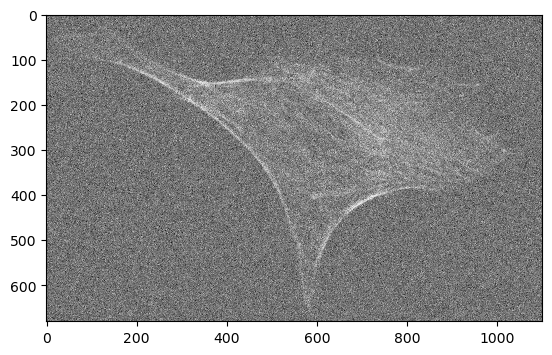

In [2]:
image = imread('../../data/BPAE_actin.tif')

# increase noise to better illustrate the effect of denoising later
noisy_image = image + np.random.normal(np.median(image), 2 * np.std(image), image.shape)

cle.imshow(noisy_image)

## Choosing a scale-factor

The scale-factor depends greatly on your analysis pipeline. Here we will mimic a common application for microscopy. Because of greater resolution of a microscope in xy (perpendicular to the optical axis) than in z (along the optical axis), data is frequently acquired with finer sampling in xy than in z. If the high xy resolution is not needed for some of the analysis steps (which is frequently the case for many segmentation tasks), it is common to down-scale the xy dimensions to match the z sampling. In our case we assume a pixel size of 0.108333 µm in xy and 1 µm in z. Therefore, we want to down-scale xy by a factor of 0.108333, which corresponds to a decimation-factor of approximately 9.

That being said, other scale-factors may be more suitable for your analysis pipeline. Ideally, you annotate some reference data and [measure the quality](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/29_algorithm_validation/segmentation_quality_estimation.html?highlight=annotation) depending on the scale-factor

In [3]:
scale_factor = 0.108333
decimation_factor = round(1 / scale_factor)

## Fast down-scaling

### Numpy slices

The absolute fastest way to down-scale data is to decimate it using numpy and an integer decimation-factor. For this we use a [slicing object to index the numpy array](https://numpy.org/doc/stable/user/basics.indexing.html#slicing-and-striding). The decimation-factor is the step size of the slicing object written as `::decimation_factor`.

The reason that this is so fast, is that numpy cleverly just creates a `view` that shows you every decimation-factor<sup>th</sup> element without moving any data around.

The disadvantage of using numpy is that you are limited to decimation, limiting you to certain scaling factors (e.g. 1/2 = 0.5, 1/3 = 0.33333, 1/4 = 0.25, etc.).


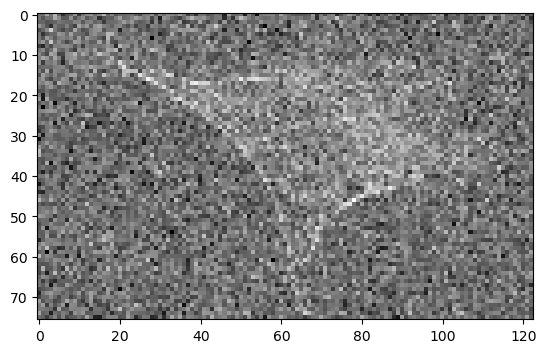

In [4]:
numpy_decimated = noisy_image[::decimation_factor, ::decimation_factor]
cle.imshow(numpy_decimated)

### Scikit-image rescale() without anti-aliasing

Scikit image comes with the rescale() function [(documentation)]](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rescale) in the `skimage.transform.rescale()` package. Without anti aliasing (argument `anti_aliasing=False`), this is also quite fast and looks similar to the data that was decimated with numpy. However, unlike numpy, this operation supports arbitrary scaling factors and is thus not limited to decimation.

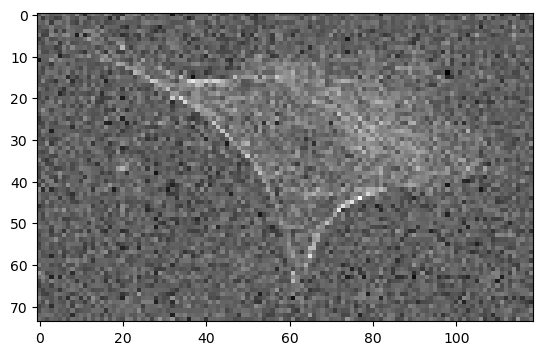

In [5]:
scikit_rescaled = sk_transform.rescale(noisy_image, scale=scale_factor, anti_aliasing=False, preserve_range=True)
cle.imshow(scikit_rescaled)

### GPU accelerated scaling

Pyclesperanto-prototype (CLE) has a GPU accelerated []`scale()` function](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier8/_AffineTransform3D.py#L31) that also supports arbitrary scaling factors and looks very similar to the options above.

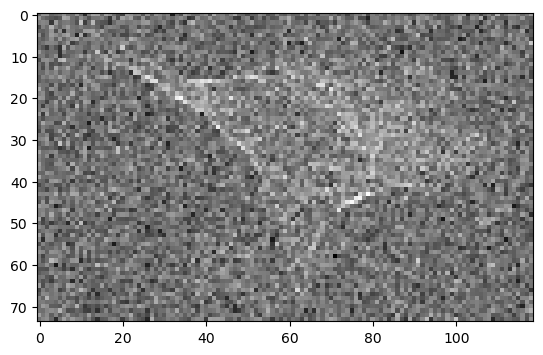

In [6]:
cle_scaled = cle.scale(noisy_image, factor_x=scale_factor, factor_y=scale_factor, auto_size=True)
cle.imshow(cle_scaled)

## Combining down-scaling and denoising

Down-sampling and denoising have in common, that they both reduce the amount of information in your data. If combined in a clever way, you loose information only once and thus end up with an improved result.

The most common way to avoid loosing more information than necessary during down-scaling [is to apply a low-pass filter before downscaling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)#Downsampling_by_an_integer_factor). This is also called anti-aliasing.

### Scikit-image rescale() with anti-aliasing

The [documentation of scikit image `rescale()``](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rescale) recommends to enable anti aliasing for down-scaling (argument `anti_aliasing=True`). Below the hood, the ant-aliasing filter of scikit-image applies a gaussian filter, the sigma of which can be controlled by the `anti_aliasing_sigma` argument. Here we use a sigma that is 4 times smaller than the scale-factor to make sure that the image is not blurred more than necessary.

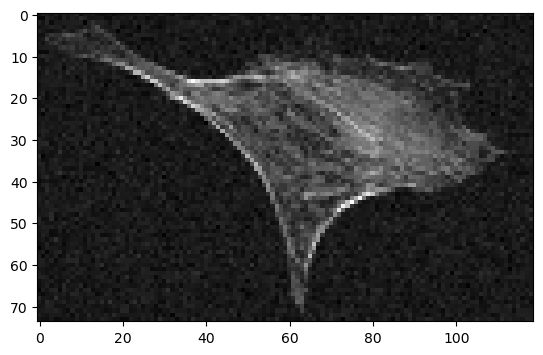

In [7]:
sigma = 1 / scale_factor / 4
scikit_rescaled_antialiasing = sk_transform.rescale(noisy_image, scale=(scale_factor, scale_factor), anti_aliasing=True, anti_aliasing_sigma=sigma)
cle.imshow(scikit_rescaled_antialiasing)

This looks a lot better than without anti-aliasing. The gaussian filter managed to remove the noise without loosing more detail than the down-sampling itself.

### GPU accelerated down-scaling with anti-aliasing

`cle.scale()` does not come with an anti-aliasing argument. However, nothing stops us from applying that filter ourselves before down-scaling. We use the same sigma as for `skimage.transform.rescale()` above.

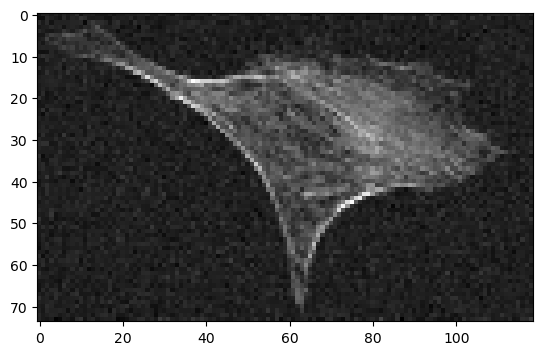

In [8]:
# first, denoise
blurred = cle.gaussian_blur(noisy_image, sigma_x=sigma, sigma_y=sigma)

# then down-scale
cle_denoised_scaled = cle.scale(blurred, factor_x=scale_factor, factor_y=scale_factor, auto_size=True)

cle.imshow(cle_denoised_scaled)

### Denoising with an average filter before down-scaling

Denoising with a gaussian filter is computationallyquite expensive, because it is applied to every pixel of the large original data. To alleviate this scikit-image provides the `skimage.transform.downscale_local_mean()` function [(documentation)](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.downscale_local_mean) that averages over the `decimation_factor` x `decimation_factor` pixels before combining them into one pixel. This means that the denoising operation is only calculated as many times as there are output pixels. The disadvantage is, that this function requires integer decimation-factors, imposing the same limitations as the numpy decimation.

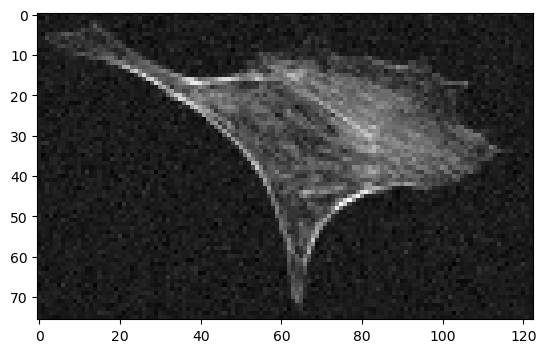

In [9]:
scikit_downsampled = sk_transform.downscale_local_mean(noisy_image, (decimation_factor, decimation_factor))
cle.imshow(scikit_downsampled)

## Side-by side comparison

Let's compare the denoising results side-by-side

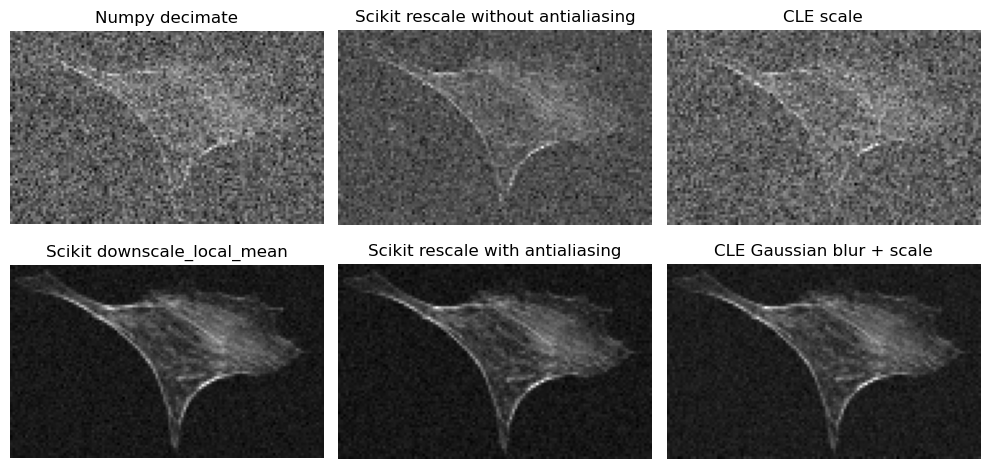

In [10]:
# Define the labels for figure titles and bar chart
labels = [
    'Numpy decimate',
    'Scikit rescale without antialiasing',
    'Scikit rescale with antialiasing',
    'Scikit downscale_local_mean',
    'CLE scale',
    'CLE Gaussian blur + scale',
]

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

axes[0, 0].imshow(numpy_decimated, cmap='gray')
axes[0, 0].set_title(labels[0])

axes[0, 1].imshow(scikit_rescaled, cmap='gray')
axes[0, 1].set_title(labels[1])

axes[0, 2].imshow(cle_scaled, cmap='gray')
axes[0, 2].set_title(labels[4])

axes[1, 0].imshow(scikit_downsampled, cmap='gray')
axes[1, 0].set_title(labels[3])

axes[1, 1].imshow(scikit_rescaled_antialiasing, cmap='gray')
axes[1, 1].set_title(labels[2])

axes[1, 2].imshow(cle_denoised_scaled, cmap='gray')
axes[1, 2].set_title(labels[5])

for ax in axes.flatten():
    ax.axis('off')

fig.tight_layout()


### Estimating signal-to-noise

In order to quantify the improvement we get through denoising, let's roughly estimate the signal to noise

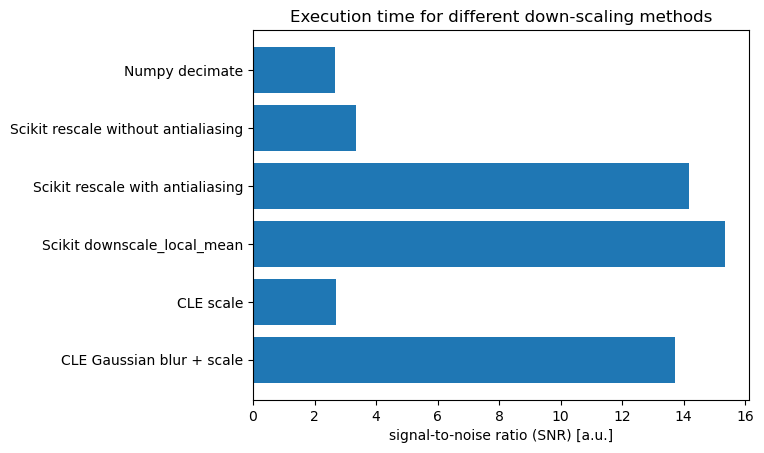

In [11]:
def calculate_snr(image):
    noise_area = image[40:, :40]
    noise = np.std(noise_area)
    signal = np.percentile(image, 98)
    snr = signal / noise
    return snr
snrs = [
    calculate_snr(numpy_decimated),
    calculate_snr(scikit_rescaled),
    calculate_snr(scikit_rescaled_antialiasing),
    calculate_snr(scikit_downsampled),
    calculate_snr(cle_scaled),
    calculate_snr(cle_denoised_scaled),
]

# Create a figure
fig, ax = plt.subplots()
ax.barh(labels, snrs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('signal-to-noise ratio (SNR) [a.u.]')
ax.set_title('Execution time for different down-scaling methods')

# Display the plot
plt.show()

The methods that denoise first and then downsample clearly superior lead to an improved signal to noise. However, how much extra computing time do they require? Let's measure it:

## Benchmarking

We perform the benchmarking on a larger image so that the measurement is more realistic for cases where the extra computation time actually matters.
We use the `timeit` module to run each method several times and measure the average execution time. The results are shown in the bar chart below.

In [12]:
# perform the benchmark on a larger image
large_image = sk_transform.rescale(image, scale=(3, 3))
large_image = np.asarray([large_image] * 100)

noisy_image = large_image + np.random.normal(np.median(image), 2 * np.std(image), large_image.shape)
print("Benchmarkint on image size: " + str(noisy_image.shape))

print("Numpy resample:")
numpy_resample_time = %timeit -o noisy_image[:, ::decimation_factor, ::decimation_factor]

print("\nScikit rescale() without antialiasing:")
sk_rescale_time = %timeit -o sk_transform.rescale(noisy_image, scale=(1, scale_factor, scale_factor), anti_aliasing=False)

print("\nScikit rescale() with antialiasing:")
sk_rescale_antialiasing_time = %timeit -o sk_transform.rescale(noisy_image, scale=(1, scale_factor, scale_factor), anti_aliasing=True)

print("\nScikit downscale_local_mean():")
sk_downscale_time = %timeit -o sk_transform.downscale_local_mean(noisy_image, (1, decimation_factor, decimation_factor))

print("\ncle.scale():")
cle_scale_time = %timeit -o cle.scale(noisy_image, factor_x=scale_factor, factor_y=scale_factor, auto_size=True)

print("\ncle.gaussian_blur() + cle.scale():")
cle_gaussian_scale_time = %timeit -o cle.scale(cle.gaussian_blur(noisy_image, sigma_x=sigma, sigma_y=sigma), factor_x=scale_factor, factor_y=scale_factor, auto_size=True)


Benchmarkint on image size: (100, 2040, 3300)
Numpy resample:
165 ns ± 5.16 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)

Scikit rescale() without antialiasing:
461 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Scikit rescale() with antialiasing:
10.2 s ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Scikit downscale_local_mean():
1.13 s ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

cle.scale():
556 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

cle.gaussian_blur() + cle.scale():
1.88 s ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


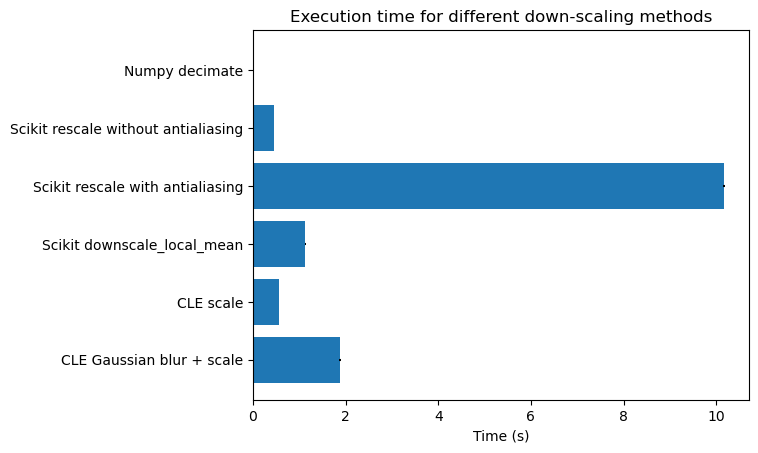

In [13]:
# Collect the average results of the %timeit runs
results = [
    numpy_resample_time.average,
    sk_rescale_time.average,
    sk_rescale_antialiasing_time.average,
    sk_downscale_time.average,
    cle_scale_time.average,
    cle_gaussian_scale_time.average
]

# Collect the standard deviations of the %timeit runs
std_devs = [
    numpy_resample_time.stdev,
    sk_rescale_time.stdev,
    sk_rescale_antialiasing_time.stdev,
    sk_downscale_time.stdev,
    cle_scale_time.stdev,
    cle_gaussian_scale_time.stdev
]


# Create a horizontal bar chart with error bars
fig, ax = plt.subplots()
ax.barh(labels, results, xerr=std_devs, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Time (s)')
ax.set_title('Execution time for different down-scaling methods')

# Display the plot
plt.show()

## Summary

Denoising before down-scaling significantly improves signal-to-noise, without loosing more detail than down-scaling alone. The additional computing time required for denoising is therefore well invested - particularly, if efficient algorithms such as `skimage.transform.downscale_local_mean()` or GPU acceleration are used.